# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1. Business Understanding
The objective here is to find patterns and show when and where to give specific offer to a specific customer.

# 2. Data Understanding

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#check profile dataframe
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [3]:
#check portfolio dataframe
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
#check transcript dataframe
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [5]:
#check profile dataframe shape
profile.shape

(17000, 5)

In [6]:
#check portfolio dataframe shape
portfolio.shape

(10, 6)

In [7]:
#check transcript dataframe shape
transcript.shape

(306534, 4)

In [8]:
#check profile dataframe properties
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
#check portfolio dataframe properties
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [10]:
#check transcript dataframe properties
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# 3. Data Preparation

As seen in section 2, the channels column of the portfolio dataframe should separated in different columns

In [11]:
#check for missing values
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [12]:
#get all channel names
channel_names = set()
for channel in portfolio.channels:
    channel_names.update(set(channel))
channel_names

{'email', 'mobile', 'social', 'web'}

In [13]:
#create dummy variables for the different channels
for channel in channel_names:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x).map({True:1, False: 0})
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward,email,web,mobile,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,0,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [14]:
#drop the initial channels column
portfolio = portfolio.drop('channels', axis=1)
portfolio.head(10)

,difficulty,duration,id,offer_type,reward,email,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,0,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [15]:
#check for missing values
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Fehlende Werte und ihr imputing erklären

In [16]:
#impute missing gender values with N/A
profile['gender'].fillna('N/A', inplace=True)

#impute missing income values with median
profile['income'].fillna((profile['income'].median()), inplace=True)

In [17]:
#check again for missing values after imputing
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [18]:
#check for missing values
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

No missing values in any of the columns of the transcript dataframe.
But the value column holds dictionaries which data should be extracted

In [19]:
# find the dictionary keys in the value column
keys = []
for idx, row in transcript.iterrows():
    for key in row['value']:
        if key in keys:
            continue
        else:
            keys.append(key)
keys

['offer id', 'amount', 'offer_id', 'reward']

In [20]:
#check the value column and put each key in a seperate column
#initalize the new columns
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for key in row['value']:
        if key == 'offer_id' or key == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][key]
        if key == 'amount':
            transcript.at[idx, 'amount']= row['value'][key]
        if key == 'reward':
            transcript.at[idx, 'reward']= row['value'][key]

In [21]:
transcript.head(10)

,event,person,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,0,0
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,0,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0


In [22]:
#drop the initial value column
transcript = transcript.drop('value', axis=1)

# 4. Data Analysis and Data Modelling

## 4.1 Data Analysis

### 4.1.1 Univariate Analysis
1) Average income of Starbucks customers? <br>
2) Median income of Starbucks customers? <br>
3) Average age of Starbucks customers? <br>
4) Median age of Starbucks customers? <br>
5) Most common promotion? <br>
6) Most common values? <br>
7) Most loyal customer? <br>

1) Average income of Starbucks customers?

In [23]:
income_mean = profile['income'].mean()
print(f'Mean Income of Starbucks Customers: {round(income_mean, 2)}$')

Mean Income of Starbucks Customers: 65225.24$


2) Median income of Starbucks customers?

In [24]:
income_median = profile['income'].median()
print(f'Median Income of Starbucks Customers: {round(income_median, 2)}$')

Median Income of Starbucks Customers: 64000.0$


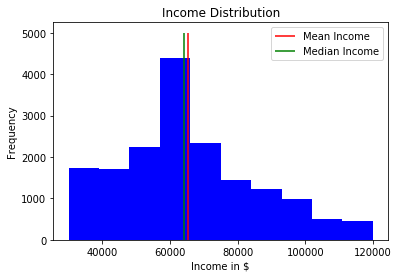

In [25]:
plt.hist(x=profile['income'],bins=10, color='blue')
plt.title('Income Distribution')
plt.xlabel('Income in $')
plt.ylabel('Frequency')
plt.vlines(income_mean, label='Mean Income', ymin=0, ymax=5000, color='red')
plt.vlines(income_median, label='Median Income', ymin=0, ymax=5000, color='green')
plt.legend()
plt.show()

3) Average age of Starbucks customers?

In [26]:
age_mean = profile['age'].mean()
print(f'Mean Age of Starbucks Customers: {round(age_mean, 2)} years')

Mean Age of Starbucks Customers: 62.53 years


4) Median age of Starbucks customers?

In [27]:
age_median = profile['age'].median()
print(f'Median Age of Starbucks Customers: {age_median} years')

Median Age of Starbucks Customers: 58.0 years


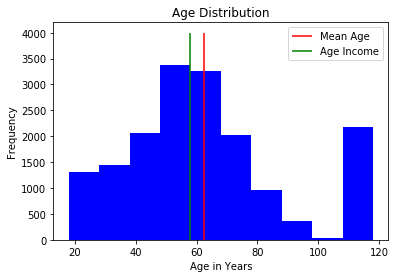

In [28]:
plt.hist(x=profile['age'],bins=10, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age in Years')
plt.ylabel('Frequency')
plt.vlines(age_mean, label='Mean Age', ymin=0, ymax=4000, color='red')
plt.vlines(age_median, label='Age Income', ymin=0, ymax=4000, color='green')
plt.legend()
plt.show()

5) Most common promotion?

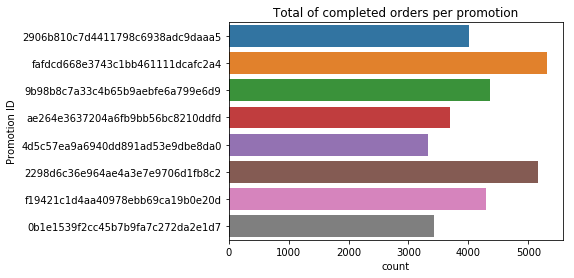

In [29]:
#Check for completed orders only
completed = transcript[transcript['event'] == 'offer completed']

sns.countplot(y=completed['offer_id'])
plt.title('Total of completed orders per promotion')
plt.ylabel('Promotion ID')
plt.show();

In [30]:
def get_type(offer_id):
    '''
    input: id of the offer - (str)
    
    output: type of the offer - (str)
    '''
    try:
        type_offer = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return type_offer
    except:
        type_offer = 'NA'
        return type_offer

#get_offer_type
transcript['type_offer'] = transcript.apply(lambda x: get_type(x['offer_id']), axis=1)

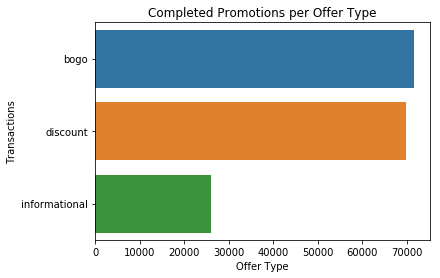

In [31]:
sns.countplot(y=transcript[transcript['type_offer'] != 'NA']['type_offer'])
plt.title('Completed Promotions per Offer Type')
plt.ylabel('Transactions')
plt.xlabel('Offer Type')
plt.show();

Buy one get one for free (Bogo) and Discount are the most common offered promotions. They are very close, but Bogo is offered slightly more often.

6) Most common values?

In [32]:
#Create an age group column for the profile dataframe based on age with the values child, teen, adult and elderly
profile['age_group'] = pd.cut(profile.age, bins=[0, 12, 18, 64, 120], labels=['child', 'teenager', 'adult', 'elderly'])

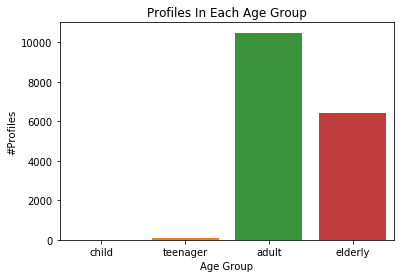

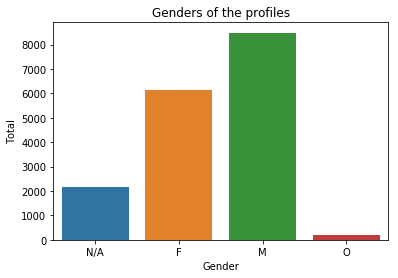

In [33]:
sns.countplot(x='age_group', data=profile)
plt.title('Profiles In Each Age Group')
plt.ylabel('#Profiles')
plt.xlabel('Age Group')
plt.show();

sns.countplot(profile['gender'])
plt.title('Genders of the profiles')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.show();

In [34]:
#Find the 20 most loyal Starbucks customers
loyal_customers = transcript[(transcript['event'] == 'offer completed') | (transcript['event'] == 'transaction')].groupby(['person', 'event'])['amount'].sum().reset_index()
loyal_customers = loyal_customers.sort_values('amount', ascending=False).head(20)
count = 1
for idx, row in loyal_customers.iterrows():
    print(f'Loyal Customer Number: {count}')
    print(f'Costumer ID: {row["person"]}')
    print(f'Completed Offers: {completed[(completed["person"] == row["person"]) & (completed["event"] == "offer completed")].shape[0]}')
    print(f'Total Amount: ${row["amount"]}')
    print('-------------------------------')
    count += 1

Loyal Customer Number: 1
Costumer ID: 3c8d541112a74af99e88abbd0692f00e
Completed Offers: 5
Total Amount: $1606
-------------------------------
Loyal Customer Number: 2
Costumer ID: f1d65ae63f174b8f80fa063adcaa63b7
Completed Offers: 6
Total Amount: $1360
-------------------------------
Loyal Customer Number: 3
Costumer ID: ae6f43089b674728a50b8727252d3305
Completed Offers: 3
Total Amount: $1320
-------------------------------
Loyal Customer Number: 4
Costumer ID: 626df8678e2a4953b9098246418c9cfa
Completed Offers: 4
Total Amount: $1314
-------------------------------
Loyal Customer Number: 5
Costumer ID: 73afdeca19e349b98f09e928644610f8
Completed Offers: 5
Total Amount: $1314
-------------------------------
Loyal Customer Number: 6
Costumer ID: 52959f19113e4241a8cb3bef486c6412
Completed Offers: 5
Total Amount: $1285
-------------------------------
Loyal Customer Number: 7
Costumer ID: ad1f0a409ae642bc9a43f31f56c130fc
Completed Offers: 3
Total Amount: $1256
-------------------------------

### 4.1.2 Multvariate Analysis

In [35]:
#Find the most common promotion for every age group
#Get age group from profile dataframe
def get_age_group(profile_id):
    age_group = profile[profile['id'] == profile_id]['age_group'].values[0]
    return age_group

transcript['age_group'] = transcript.apply(lambda x: get_age_group(x['person']), axis=1)

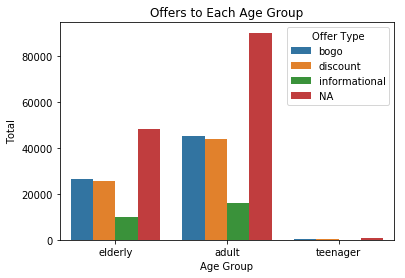

In [36]:
sns.countplot(x="age_group", hue="type_offer", data=transcript)
plt.title('Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.legend(title='Offer Type')
plt.show();

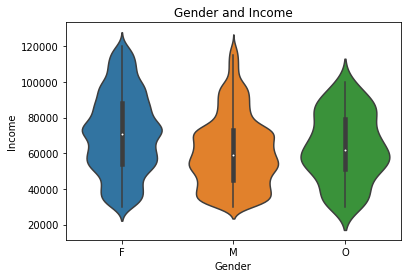

In [37]:
sns.violinplot(x=profile[profile['gender'] != 'N/A']['gender'], y=profile['income'])
plt.title('Gender and Income')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.show();

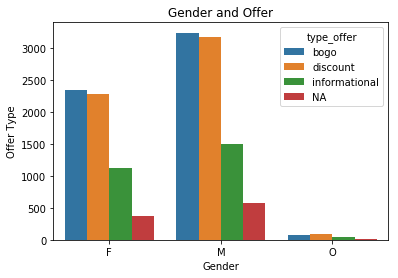

In [38]:
sns.countplot(x=profile[profile['gender'] != 'N/A']['gender'], hue = 'type_offer', data=transcript)
plt.title('Gender and Offer')
plt.ylabel('Offer Type')
plt.xlabel('Gender')
plt.show();

## 4. Modelling

In [39]:
transcript = transcript[transcript['offer_id'] != 'N/A']

In [40]:
def get_gender(profile_id):
    gender = profile[profile['id'] == profile_id]['gender'].values[0]
    return gender

transcript['gender'] = transcript.apply(lambda x: get_gender(x['person']), axis=1)

In [41]:
def get_income(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

transcript['income'] = transcript.apply(lambda x: get_income(x['person']), axis=1)

In [42]:
transcript.head(10)

,event,person,time,offer_id,amount,reward,type_offer,age_group,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,elderly,F,100000.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,elderly,N/A,64000.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,elderly,M,70000.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount,elderly,N/A,64000.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo,elderly,N/A,64000.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,bogo,elderly,M,53000.0
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,discount,elderly,N/A,64000.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,0,informational,adult,M,51000.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,adult,F,57000.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,adult,F,71000.0


In [43]:
#Input features for the models
labels_event = transcript['event'].astype('category').cat.categories.tolist()
event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
print(event)

labels_offer_id = transcript['offer_id'].astype('category').cat.categories.tolist()
offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(offer_id)

labels_age_group = transcript['age_group'].astype('category').cat.categories.tolist()
age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(age_group)

labels_gender = transcript['gender'].astype('category').cat.categories.tolist()
gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
print(gender)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'': 1, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 2, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, '2906b810c7d4411798c6938adc9daaa5': 4, '3f207df678b143eea3cee63160fa8bed': 5, '4d5c57ea9a6940dd891ad53e9dbe8da0': 6, '5a8bc65990b245e5a138643cd4eb9837': 7, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 8, 'ae264e3637204a6fb9bb56bc8210ddfd': 9, 'f19421c1d4aa40978ebb69ca19b0e20d': 10, 'fafdcd668e3743c1bb461111dcafc2a4': 11}}
{'age_group': {'adult': 1, 'elderly': 2, 'teenager': 3}}
{'gender': {'F': 1, 'M': 2, 'N/A': 3, 'O': 4}}


In [44]:
#Output/dependend variable
labels_offer_type = transcript['type_offer'].astype('category').cat.categories.tolist()
offer_type = {'type_offer' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(offer_type)

{'type_offer': {'NA': 1, 'bogo': 2, 'discount': 3, 'informational': 4}}


In [45]:
#Replace categorical values with numerical values
transcript.replace(event, inplace=True)
transcript.replace(offer_id, inplace=True)
transcript.replace(age_group, inplace=True)
transcript.replace(gender, inplace=True)

transcript.replace(offer_type, inplace=True)

In [46]:
transcript.head(10)

,event,person,time,offer_id,amount,reward,type_offer,age_group,gender,income
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,8,0,0,2,2,1,100000.0
1,2,a03223e636434f42ac4c3df47e8bac43,0,2,0,0,3,2,3,64000.0
2,2,e2127556f4f64592b11af22de27a7932,0,4,0,0,3,2,2,70000.0
3,2,8ec6ce2a7e7949b1bf142def7d0e0586,0,11,0,0,3,2,3,64000.0
4,2,68617ca6246f4fbc85e91a2a49552598,0,6,0,0,2,2,3,64000.0
5,2,389bc3fa690240e798340f5a15918d5c,0,10,0,0,2,2,2,53000.0
6,2,c4863c7985cf408faee930f111475da3,0,3,0,0,3,2,3,64000.0
7,2,2eeac8d8feae4a8cad5a6af0499a211d,0,5,0,0,4,1,2,51000.0
8,2,aa4862eba776480b8bb9c68455b8c2e1,0,2,0,0,3,1,1,57000.0
9,2,31dda685af34476cad5bc968bdb01c53,0,2,0,0,3,1,1,71000.0


In [47]:
# Split the data into input variables/features and output variables/target variables
output = transcript['type_offer']
input_features = transcript.drop(['person', 'type_offer'], axis = 1)

In [48]:
output.head(10)

0    2
1    3
2    3
3    3
4    2
5    2
6    3
7    4
8    3
9    3
Name: type_offer, dtype: int64

In [49]:
input_features.head(10)

,event,time,offer_id,amount,reward,age_group,gender,income
0,2,0,8,0,0,2,1,100000.0
1,2,0,2,0,0,2,3,64000.0
2,2,0,4,0,0,2,2,70000.0
3,2,0,11,0,0,2,3,64000.0
4,2,0,6,0,0,2,3,64000.0
5,2,0,10,0,0,2,2,53000.0
6,2,0,3,0,0,2,3,64000.0
7,2,0,5,0,0,1,2,51000.0
8,2,0,2,0,0,1,1,57000.0
9,2,0,2,0,0,1,1,71000.0


In [50]:
scaler = MinMaxScaler()
normalize = ['time', 'amount', 'reward', 'income']

input_features[normalize] = scaler.fit_transform(input_features[normalize])
input_features.head(10)

,event,time,offer_id,amount,reward,age_group,gender,income
0,2,0.0,8,0.0,0.0,2,1,0.777778
1,2,0.0,2,0.0,0.0,2,3,0.377778
2,2,0.0,4,0.0,0.0,2,2,0.444444
3,2,0.0,11,0.0,0.0,2,3,0.377778
4,2,0.0,6,0.0,0.0,2,3,0.377778
5,2,0.0,10,0.0,0.0,2,2,0.255556
6,2,0.0,3,0.0,0.0,2,3,0.377778
7,2,0.0,5,0.0,0.0,1,2,0.233333
8,2,0.0,2,0.0,0.0,1,1,0.300000
9,2,0.0,2,0.0,0.0,1,1,0.455556


In [51]:
X_train, X_test, y_train, y_test = train_test_split(input_features, output, random_state=0)

In [52]:
print('Training Input Variables/Features Shape:', X_train.shape)
print('Training Output Variable Shape:', y_train.shape)
print('Testing Input Variables/Features Shape:', X_test.shape)
print('Testing Output Variable Shape:', y_test.shape)

Training Input Variables/Features Shape: (229900, 8)
Training Output Variable Shape: (229900,)
Testing Input Variables/Features Shape: (76634, 8)
Testing Output Variable Shape: (76634,)


### Logistic Regression

In [53]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Logistic Regression Classifier: {round(accuracy*100,2)}%')

Accuracy Logistic Regression Classifier: 80.54%


### K-Nearest Neighbor

In [54]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy KNN Classifier: {round(accuracy*100,2)}%')

Accuracy KNN Classifier: 100.0%


### Decision Tree

In [55]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Decision Tree Classifier: {round(accuracy*100,2)}%')

Accuracy Decision Tree Classifier: 100.0%


### Support Vector Machine

In [56]:
svm = SVC()

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Support Vector Machine Classifier: {round(accuracy*100, 2)}%')

Accuracy Support Vector Machine Classifier: 100.0%


### Random Forest

In [57]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 30)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Random Forest Classifier: {round(accuracy*100, 2)}%')

Accuracy Random Forest Classifier: 100.0%


### Naive Bayes Classifier

In [58]:
naive_bayes = GaussianNB() 
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Naive Bayes Classifier: {round(accuracy*100,2)}%')

Accuracy Naive Bayes Classifier: 72.71%


## Model Results / Evalutation
Based on the models' results above four of six models show a prediction accuracy of 100% on the testing data which indicate the models KNN, Decision Tree, Random Forest and SVM can be used to classify the type of the offers very well.

# Conclusion
In this project, the data was first analyzed in an explorative way. As a part of the explorative analysis, the data was checked, cleaned and missing values were imputed. Furthermore, important statistics were visualized.
After this explorative analysis different models were trained and tested to predict the best offer for a given Starbucks customer.
As a result of the analysis, Starbucks should place more offers to woman than men because women had more completed offers. Furthermore, Starbucks should focus on the offer types Buy one get one for free and Discount since these offers make costumers to buy more.